<h1>Creating and Testing a Bank Model for leaving Customers</h1>
<h2>Importing Dependencies, Cleaning DataFrame, and Variable Construction</h2>
</br>&nbsp;&nbsp;&nbsp;&nbsp;I'm going to start by importing all of the regression models to help me see which model would be best to used, my suspicion is that the Decsion Tree will be the more accurate model albeit a little more time demanding. I believe it is better to be safe than sorry when determining what plays into people choosing to leave and who we should be targeting for retention. I'm going to follow the imports with a new feature column that represents if the "Tenure" column was empty before filling each empty column with the respective means from each of the three countries with missing values. (France, Spain, and Germany). After which will be the construction of the testing set, comprising of 15% the original data.</br>&nbsp;&nbsp;&nbsp;&nbsp; I will be encoding the categorical data for processing. So in addtion to the Testing set comprising 15% of the Data, it will be followed by creating a training set of 70% the original data and leaving 15% remaining for an inital validation test which will be used with each model at construction. 

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

customer_info = pd.read_csv('/datasets/Churn.csv')
state=54321
n_jobs=2

In [11]:
# This is to allow feature engineering on missing Tenure rows for after I fill them.
customer_info['Tenure_missing'] = customer_info['Tenure'].isna().astype(int)

# Filling missing Tenure values with the average Tenure for each Country
customer_info['Tenure'] = customer_info.groupby('Geography')['Tenure'].apply(lambda x: x.fillna(x.mean()))

# Displaying the Data to use as a reference
display(customer_info.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_missing
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1,0
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1,0
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0,0


<h3>Processing the Data</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;Processing the Data for any duplicates, and understanding the different metrics.

In [12]:
customer_info = customer_info.drop_duplicates()
for column in customer_info.columns:
    duplicate_count = customer_info.duplicated(subset=column, keep=False).sum()
    print(f'{column}: {duplicate_count}')

RowNumber: 0
CustomerId: 0
Surname: 8442
CreditScore: 9977
Geography: 10000
Gender: 10000
Age: 9996
Tenure: 10000
Balance: 3621
NumOfProducts: 10000
HasCrCard: 10000
IsActiveMember: 10000
EstimatedSalary: 2
Exited: 10000
Tenure_missing: 10000


In [13]:
# Pulling Features and Target
features_raw = customer_info.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
features = pd.get_dummies(features_raw, columns=['Geography', 'Gender'], drop_first=True)
target = customer_info['Exited']

In [14]:
## VALID SET ## (15%) Untouched
# Pulling 15% out of the Data to validate the Trained Model against in the future
valid_set = customer_info.sample(frac=0.15, random_state=12345)

# Align columns with training features
features_valid = features.loc[valid_set.index]
target_valid = target.loc[valid_set.index]

features = features.drop(valid_set.index)
target = target.drop(valid_set.index)

In [15]:
## TRAINING AND TESTING SET ## (70% and 15% respectively)
# Splitting the remaining data into a Testing Set (15% of Total) and a Training Set (70% of Total)
data = customer_info.drop(valid_set.index)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1765, random_state=state)

In [16]:
# Reviewer's code 2.1 

print("customer_info dataframe: ", len(customer_info))

print("All subsets: ", len(features_train) + len(features_valid) + len(features_test))

# Intersection is not empty:
print(features_train.index.intersection(features_valid.index))


# Another intersection:
print(features_valid.index.intersection(features_test.index))

customer_info dataframe:  10000
All subsets:  10000
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [17]:
# Reviewer's code 2.2 train-valid intersection

#intersection1 = features_valid.index.intersection(features_train.index)[0]
#print(features_train.loc[intersection1])
#print(features_valid.loc[intersection1])

In [18]:
# Reviewer's code 2.3 test-valid intersection

#intersection2 = features_valid.index.intersection(features_test.index)[0]
#print(features_test.loc[intersection2])
#print(features_valid.loc[intersection2])

In [19]:
# Setting Raw Features and Targets before resampling, scaling, and poly features
features_valid_raw = features_valid
target_valid_raw = target_valid

features_train_raw = features_train
target_train_raw = target_train

features_test_raw = features_test
target_test_raw = target_test

In [20]:
def downsample(features, target, fraction):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=state)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=state)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=state
    )

    return features_downsampled, target_downsampled

def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=state
    )

    return features_upsampled, target_upsampled

In [21]:
# Scaling the Sets
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)  

# Implementing Upsampling
features_upsampled, target_upsampled = upsample(
    features_train_scaled, target_train, 10
)

# Implementing Downsampling
features_downsampled, target_downsampled = downsample(
    features_train_scaled, target_train, 0.1
)

features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=state
)

features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=state
)

In [22]:
# Introducing Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

features_train = poly.fit_transform(features_upsampled)
target_train = target_upsampled
features_down_train = poly.fit_transform(features_downsampled)
target_down_train = target_downsampled
features_valid = poly.transform(features_valid_scaled)
features_test = poly.transform(features_test_scaled)

<h3>Plotting the Processed Data and Features</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;To better understand the relationship between the different metrics I will plot the different values within each numeric column of my models features using a combination of box_plots and histograms. 

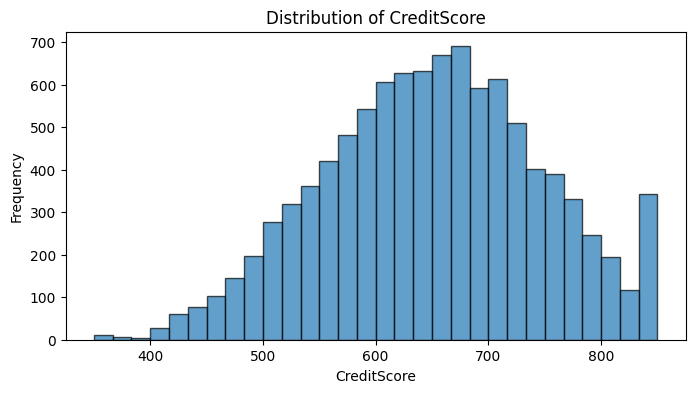

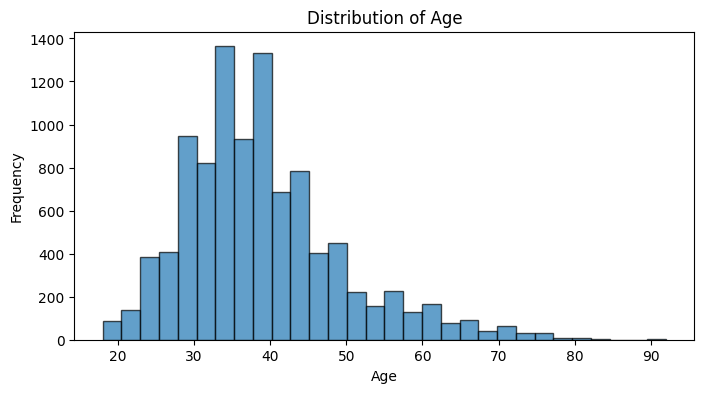

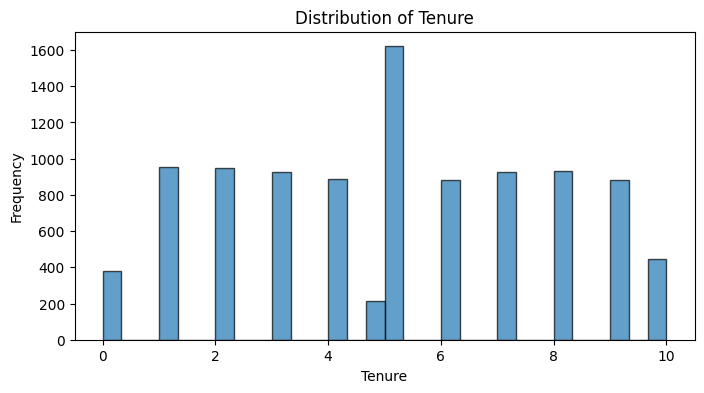

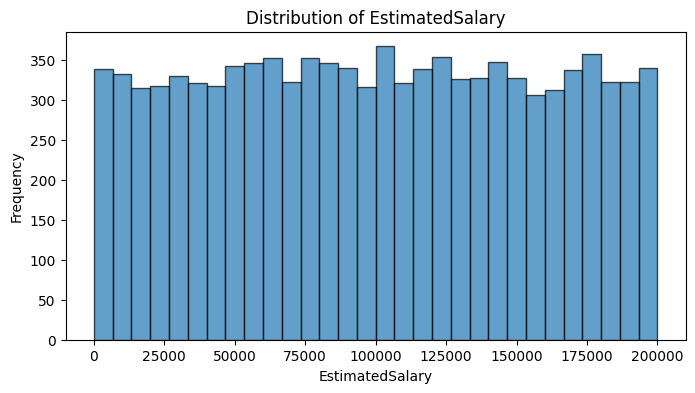

In [23]:
for column in ['CreditScore', 'Age', 'Tenure', 'EstimatedSalary']:
   plt.figure(figsize=(8, 4))
   plt.hist(customer_info[column], bins=30, edgecolor='k', alpha=0.7)
   plt.title(f'Distribution of {column}')
   plt.xlabel(column)
   plt.ylabel('Frequency')
   plt.show()

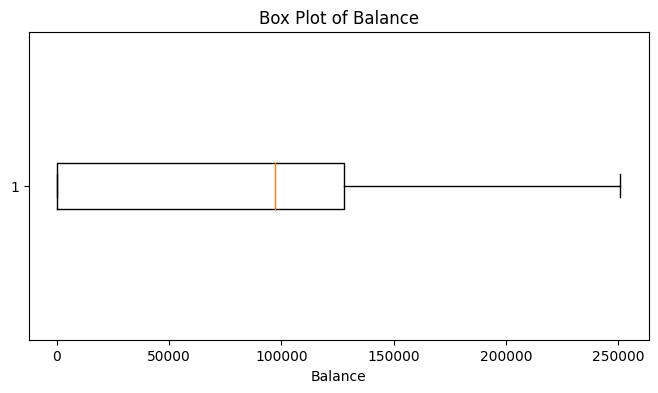

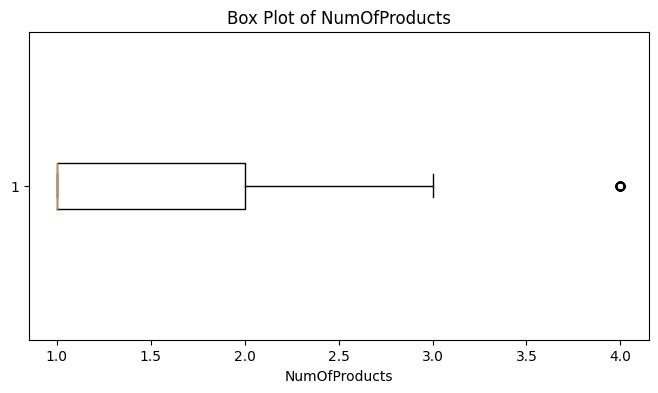

In [24]:
# Plotting features that looked like they had outliers to understnad how it affects mean and values.
for column in ['Balance', 'NumOfProducts']:
       plt.figure(figsize=(8, 4))
       plt.boxplot(data[column], vert=False)
       plt.title(f'Box Plot of {column}')
       plt.xlabel(column)
       plt.show()

<h3>Plotting Observations</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;Looking over the graphs I noticed the most common balance value is 0, which could heavily disrupt that metric within the models and that most people have only a single product with the bank which might make that metric imbalenced as well.

<h2>Building the Models</h2>
<h3>Descision Tree</h3>
&nbsp;&nbsp;&nbsp;&nbsp;I'm going to start with my suspicion to see how accurate of a model it turns up. I'm going to run some code to find the optimal depth to achieve the highest accuracy score. I'm going to be putting the best foot forward on each of these test to determine the more accurate model. 

In [16]:
# Before Processing Class Imbalence
best_score_raw = 0
best_depth_raw = 0
best_sample_raw = 0
best_leaf_raw = 0

for min_samp in range(2, 10):
    for leaf in range(2, 10):
        for depth in range(1, 11):
            raw_tree_model = DecisionTreeClassifier(
                random_state=state,
                max_depth=depth, 
                min_samples_split= min_samp,
                min_samples_leaf = leaf)
            raw_tree_model.fit(features_train_raw, target_train_raw)
            predict_test_raw = raw_tree_model.predict(features_test_raw)
            score = round(f1_score(target_test_raw, predict_test_raw), 2)
            if score > best_score_raw:
                best_score_raw = score
                best_depth_raw = depth
                best_sample_raw = min_samp
                best_leaf_raw = leaf

print('Raw Accuracy - '
      f'Best set - F1 Score: {best_score_raw}, '
      f'Depth: {best_depth_raw}, '
      f'Best_Sample_Size: {best_sample_raw}, ' 
      f'Best_Leaf: {best_leaf_raw}')

# Training the Best model for AUC-ROC Graph
raw_tree_model = DecisionTreeClassifier(random_state=state, max_depth=best_depth_raw, min_samples_split=best_sample_raw)
raw_tree_model.fit(features_train_raw, target_train_raw)

Raw Accuracy - Best set - F1 Score: 0.59, Depth: 5, Best_Sample_Size: 2, Best_Leaf: 5


DecisionTreeClassifier(max_depth=5, random_state=54321)

In [17]:
best_score = 0
best_depth = 0
best_sample = 0
best_leaf = 0

for min_samp in [10, 15, 20]:
    for leaf in [2, 6, 10, 15]:
        for depth in [20, 25, 30]:
            tree_model = DecisionTreeClassifier(
                random_state=state, 
                max_depth=depth, 
                min_samples_split= min_samp,
                min_samples_leaf = leaf)
            tree_model.fit(features_train, target_train) # Using the Training set for training the data
            predict_test = tree_model.predict(features_test)
            score = round(f1_score(target_test, predict_test), 2) # Using the Test set to tune hyper variables
            if score > best_score:
                best_score = score
                best_depth = depth
                best_sample = min_samp
                best_leaf = leaf

print('Accuracy - '
      f'Best set - F1 Score: {best_score}, '
      f'Depth: {best_depth}, '
      f'Best_Sample_Size: {best_sample}, ' 
      f'Best_Leaf: {best_leaf}')

# Training the Best model for AUC-ROC Graph
tree_model = DecisionTreeClassifier(random_state=state, max_depth=depth, min_samples_split=best_sample)
tree_model.fit(features_train, target_train)

Accuracy - Best set - F1 Score: 0.55, Depth: 25, Best_Sample_Size: 10, Best_Leaf: 10


DecisionTreeClassifier(max_depth=30, min_samples_split=10, random_state=54321)

AUC: 0.8425679868879588


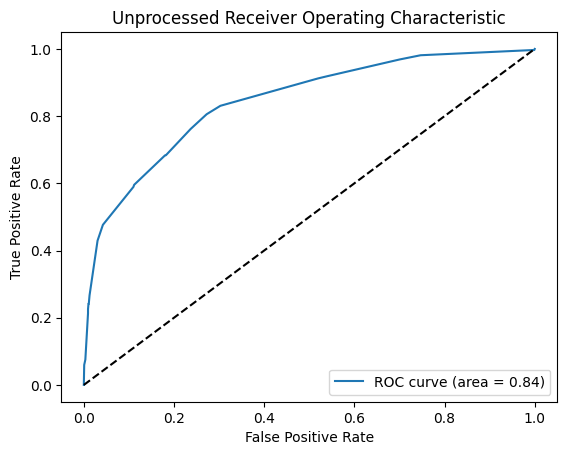

AUC: 0.6603692270154725


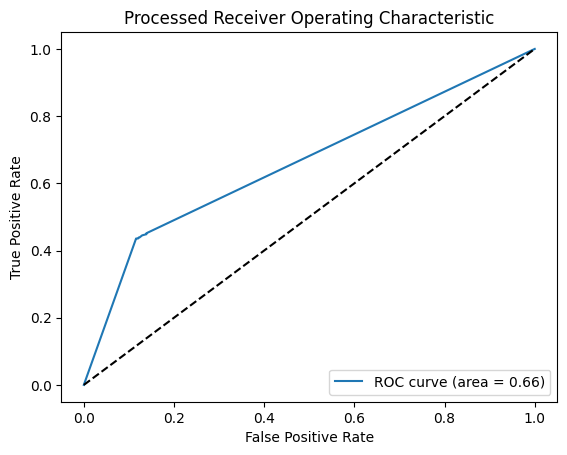

In [18]:
## Unprocessed Data ##

predicted_probs = raw_tree_model.predict_proba(features_test_raw)[:, 1]  # Probabilities for the positive class

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test_raw, predicted_probs)

# AUC
auc = roc_auc_score(target_test_raw, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unprocessed Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Processed Data ##

predicted_probs = tree_model.predict_proba(features_test)[:, 1]  # Probabilities for the positive class

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)

# AUC
auc = roc_auc_score(target_test, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Processed Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
display('Unprocessed Features Importances')
importances = raw_tree_model.feature_importances_
feature_names = features.columns

# Pair feature names with their importances
feature_importance = zip(feature_names, importances)

# Sort and display
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature in sorted_importance:
    print(feature)

display('Processed Features Importances')
importances = tree_model.feature_importances_
feature_names = features.columns

# Pair feature names with their importances
feature_importance = zip(feature_names, importances)

# Sort and display
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature in sorted_importance:
    print(feature)

'Unprocessed Features Importances'

('Age', 0.4118586360407235)
('NumOfProducts', 0.3327282319328752)
('IsActiveMember', 0.13267045936645783)
('Balance', 0.07068834344184406)
('Geography_Germany', 0.04168557023638415)
('EstimatedSalary', 0.010133776640067982)
('CreditScore', 0.00023498234164726992)
('Tenure', 0.0)
('HasCrCard', 0.0)
('Tenure_missing', 0.0)
('Geography_Spain', 0.0)
('Gender_Male', 0.0)


'Processed Features Importances'

('Age', 0.13637072500843186)
('Balance', 0.030578052052456006)
('IsActiveMember', 0.01113470708595413)
('EstimatedSalary', 0.009598608491754)
('Tenure', 0.002449824300547034)
('CreditScore', 0.002275047225402706)
('HasCrCard', 0.0002491819297092441)
('NumOfProducts', 0.0)
('Tenure_missing', 0.0)
('Geography_Germany', 0.0)
('Geography_Spain', 0.0)
('Gender_Male', 0.0)


<h3>Decision Tree Observations</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;Thats a curious observation, the Decision Tree Preformed better with the unfiltered/unprocessed data than with the resampling and scaling. In fact, based off the importances of each model it seems the polynominal features and scaling has made many valuable impressions from the raw features "unnecessary" for the model and the AUC-ROC and F1 Score see a major hit because of it. </br>
&nbsp;&nbsp;&nbsp;&nbsp;That being said, a 63 F1 Score and a 78 AUC-ROC make for a seemingly reliable model, with unprocessed features.

<h3>Random Forest</h3>
&nbsp;&nbsp;&nbsp;&nbsp;Moving on to the Random Forest since I wasn't able to get Descision Tree over an F1 Score of 57 on the testing set. Like I did with the Descision Tree I'm going to implement the most accurate results by finding the optimal variables for estimators and depth.

In [26]:
## Unprocessed Random Forest ##

raw_tree_best_score = 0
raw_best_est = 1 # Best number of Trees
raw_best_depth = 1 # Best Depth
raw_best_split = 2 # Best number of trees before split
raw_best_leaf = 1 # Best node amount to make a leaf

for depth in range(10, 20):
    for est in range(1, 10):
        for split in [2, 5, 10]:
            for leaf in [1, 2, 4]:
                raw_forest_model = RandomForestClassifier(
                    random_state=state,
                    n_jobs=n_jobs,
                    n_estimators=est,
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf
                )
        raw_forest_model.fit(features_train_raw, target_train_raw)
        raw_predict_test = raw_forest_model.predict(features_test_raw)
        score = round(f1_score(target_test_raw, raw_predict_test), 2)
        if score > raw_tree_best_score:
            raw_tree_best_score = score
            raw_best_est = est
            raw_best_depth = depth
            raw_best_split = split
            raw_best_leaf = leaf

print("Best model parameters: n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}".format(
    raw_best_est, raw_best_depth, raw_best_split, raw_best_leaf))
print(f"Best F1 Score: {raw_tree_best_score}")

# Training the Best model for AUC-ROC Graph
raw_forest_model = RandomForestClassifier(random_state=state, 
                                          n_jobs=n_jobs,
                                          n_estimators=raw_best_est,
                                          max_depth=raw_best_depth,
                                          min_samples_split=raw_best_split,
                                          min_samples_leaf=raw_best_leaf)
raw_forest_model.fit(features_train_raw, target_train_raw)

Best model parameters: n_estimators = 4, max_depth = 17, min_samples_split = 10, min_samples_leaf = 4
Best F1 Score: 0.59


RandomForestClassifier(max_depth=17, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=4, n_jobs=2, random_state=54321)

In [25]:
## Processed Random Forest ##

tree_best_score = 0
best_est = 0
best_depth = 1
best_split = 2
best_leaf = 1

for depth in range(17, 20):
    for est in range(4, 7):
        for split in [2, 5, 10]:
            for leaf in [1, 2, 4]:
                forest_model = RandomForestClassifier(
                    random_state=state,
                    n_estimators=est,
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf
                )
                forest_model.fit(features_train, target_train)
                predict_test = forest_model.predict(features_test)
                score = round(f1_score(target_test, predict_test), 2)
                if score > tree_best_score:
                    tree_best_score = score
                    best_est = est
                    best_depth = depth
                    best_split = split
                    best_leaf = leaf

print("Best model parameters: n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}".format(
    best_est, best_depth, best_split, best_leaf))
print(f'Best Model Score: {tree_best_score}')

# Training the Best model for AUC-ROC Graph
forest_model = RandomForestClassifier(random_state=state, 
                                      n_estimators=best_est, 
                                      max_depth=best_depth,
                                      min_samples_split=best_split,
                                      min_samples_leaf=best_leaf)
forest_model.fit(features_train, target_train)

Best model parameters: n_estimators = 6, max_depth = 18, min_samples_split = 10, min_samples_leaf = 4
Best Model Score: 0.63


RandomForestClassifier(max_depth=18, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=6, random_state=54321)

AUC: 0.8374334982946922


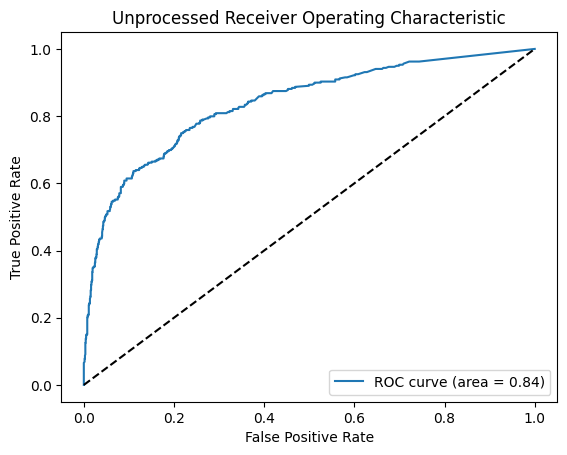

AUC: 0.8454866360082534


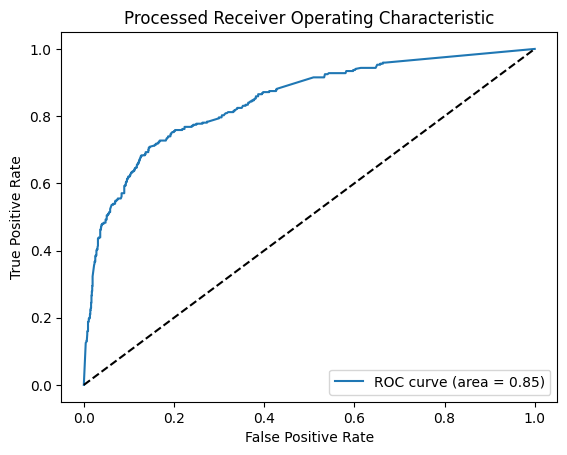

In [27]:
## Unprocessed ##

predicted_probs = raw_forest_model.predict_proba(features_test_raw)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test_raw, predicted_probs)

# AUC
auc = roc_auc_score(target_test_raw, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unprocessed Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Processed ##

predicted_probs = forest_model.predict_proba(features_test)[:, 1]  # Probabilities for the positive class

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)

# AUC
auc = roc_auc_score(target_test, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Processed Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
display('Unprocessed Features Importances')
importances = raw_forest_model.feature_importances_
feature_names = features.columns

# Pair feature names with their importances
feature_importance = zip(feature_names, importances)

# Sort and display
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature in sorted_importance:
    print(feature)

display('Processed Features Importances')
importances = forest_model.feature_importances_
feature_names = features.columns

# Pair feature names with their importances
feature_importance = zip(feature_names, importances)

# Sort and display
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature in sorted_importance:
    print(feature)

'Unprocessed Features Importances'

('Age', 0.29998362306120263)
('NumOfProducts', 0.22102323782243163)
('Balance', 0.10083762993903161)
('CreditScore', 0.09955905253794906)
('EstimatedSalary', 0.07876839615383521)
('Tenure', 0.05850622667769614)
('IsActiveMember', 0.0567697850000896)
('Geography_Germany', 0.04047779278158236)
('Gender_Male', 0.016584987006619426)
('HasCrCard', 0.012880231418781463)
('Geography_Spain', 0.008976503758211355)
('Tenure_missing', 0.005632533842569452)


'Processed Features Importances'

('Age', 0.06726613097265641)
('Balance', 0.029675629042569467)
('NumOfProducts', 0.02205072363684901)
('EstimatedSalary', 0.015563366745847624)
('CreditScore', 0.012623396513730458)
('IsActiveMember', 0.008260679408035326)
('Tenure', 0.005721082665382664)
('Gender_Male', 0.0049496093946947315)
('Geography_Spain', 0.0015814704980617296)
('Tenure_missing', 0.0015550329589387078)
('HasCrCard', 0.0007871189990699691)
('Geography_Germany', 0.0)


<h3>Random Forest Observations</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;Several interesting observations made here between the processed and unprocessed models.
<ol>
    <li>Would have to be the discripencies in the value between the classes. Age is number one in both but everything went down by a tenth of importance during the varying methods of processing.</li>
    <li>Another observation is how, despite the changes in class order, the AUC-ROC and F1 Score didn't have a lot of variance, between the two models on the validation set.</li>
</ol>
&nbsp;&nbsp;&nbsp;&nbsp;This implies that the Random Forest Model, doesn't seem to be very affected by the scaling and polynomial features. With an AUC-ROC of 85 for the Unprocessed features that seems to be the winner between Decsion Tree and Random Forest. Clearly with the variance of Trees and estimators Random Forest is able to pick up on more details than the Decsision Tree.

<h3>Logisitic Regression</h3>
&nbsp;&nbsp;&nbsp;&nbsp;That F1 Score on the Validation Set is a little crazy so I'm going to explore the Logisitic Regrssion Model to see waht that offers.

In [29]:
# Using Grid Search to find the most robust parameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.1, 10],
    'solver': ['liblinear', 'saga'],
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), 
                           param_grid, scoring='f1', cv=5)
grid_search.fit(features_train, target_train)

# Printing the best parameters to implement
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [30]:
# Implementing those best parameters
LR_model = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=1000, 
                           random_state=state)
LR_model.fit(features_train, target_train)

# Testing the Fresh Model against the Seperate Validation Set
predict_valid = LR_model.predict(features_test)
print(f'F1 Score on upsampled seperated Validation set: {round(f1_score(target_test, predict_test), 2)}')

F1 Score on upsampled seperated Validation set: 0.61


In [31]:
# Using Grid Search to find the most robust parameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.1, 10],
    'solver': ['liblinear', 'saga'],
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), 
                           param_grid, scoring='f1', cv=5)
grid_search.fit(features_down_train, target_down_train)

# Printing the best parameters to implement
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [32]:
# Implementing those best parameters
LR_down_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, 
                           random_state=state)
LR_down_model.fit(features_down_train, target_down_train)

# Testing the Fresh Model against the Seperate Validation Set
predict_valid = LR_model.predict(features_test)
print(f'F1 Score on downsampled seperated Validation set: {round(f1_score(target_test, predict_test), 2)}')

F1 Score on downsampled seperated Validation set: 0.61


AUC: 0.7772305586938879


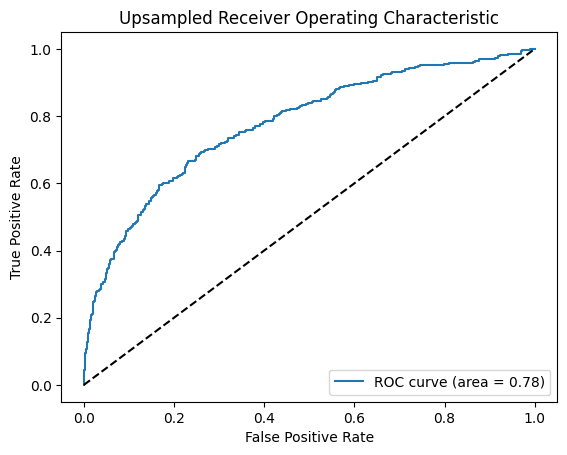

AUC: 0.7807870407205257


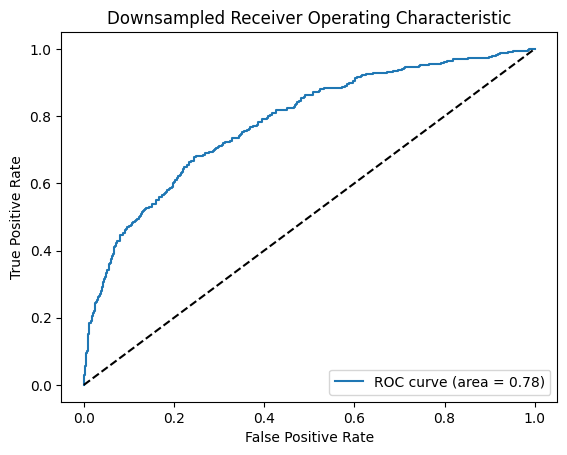

In [34]:
## Up sampled ##
predicted_probs = LR_model.predict_proba(features_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)

# AUC
auc = roc_auc_score(target_test, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Upsampled Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Down Sampled ##
predicted_probs = LR_down_model.predict_proba(features_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)

# AUC
auc = roc_auc_score(target_test, predicted_probs)
print("AUC:", auc)

# Plotting
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Downsampled Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<h3>If it wasn't for that F1 Score</h3></br>
&nbsp;&nbsp;&nbsp;&nbsp;The Logisitic Regression Model seems to be the most finicky and least intuitive model. I'd imagine with more practice and tuning of the hyper parameters I could get this model to preform better but as it stands right now I haven't been able to get it past an F1 Score of 53.

<h2>Making a Seperate Testing Section for the best Model</h2></br>
&nbsp;&nbsp;&nbsp;&nbsp;Reviewing the models I have choosen the unprocessed Random Forest, simply because it handled the class structure of the data the best, was the most intuitive, and held the highest AUC-ROC score from the testing set.

In [37]:
# Testing the Raw Random Forest Model against the Seperate Validation Set
predict_valid = forest_model.predict(features_valid) 
print(f'F1 Score on the seperated Validation set: {round(f1_score(target_valid, predict_valid), 2)}')

F1 Score on the seperated Validation set: 0.59


In [35]:
# Reviewer's code 5 

data = pd.get_dummies(customer_info, drop_first=True, columns=['Geography', 'Gender'])


data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=12)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12)

data_features_train = data_train.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
data_target_train = data_train['Exited']
data_features_valid = data_valid.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
data_target_valid = data_valid['Exited']
data_features_test = data_test.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
data_target_test = data_test['Exited']



data_features_train_up, data_target_train_up = upsample(data_features_train, data_target_train, 10)

best_F1 = 0

for estim in range(20, 80, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim)

    model.fit(data_features_train_up, data_target_train_up)
    predicted_valid = model.predict(data_features_valid)
    probablities_valid = model.predict_proba(data_features_valid)[:, 1]
    
    f1 = f1_score(data_target_valid, predicted_valid)
    
    if f1 > best_F1:
        best_F1 = f1
        best_estim = estim
        best_model = model
        
print("estimators: ", best_estim)
print('F1: ', best_F1)

estimators:  70
F1:  0.5754985754985755


In [36]:
# Reviewer's code 5 

predicted_test = best_model.predict(data_features_test)
probablities_test = best_model.predict_proba(data_features_test)[:, 1]

print('F1 =', f1_score(data_target_test, predicted_test))
print('AUC-ROC =', roc_auc_score(data_target_test, probablities_test))

F1 = 0.6149870801033591
AUC-ROC = 0.8446892817757338


<h2>Conclusion</h2></br>
&nbsp;&nbsp;&nbsp;&nbsp;With the complexity of the information and how each feature interacts, the Random Forest model stands out, achieving an F1 Score of 0.59 on the validation set and an AUC of 0.84. This indicates strong performance and robustness in capturing the intricacies of the dataset.</br>
&nbsp;&nbsp;&nbsp;&nbsp;After reviewing the Features and their respective importance in the Random Forest Model you will see that Age followed by financial health metrics are the major contribitors to whether a client will be leaving the bank. With this knowledge, and the assistance of personalized detail utilizing the models help, I would suggest we develop retention strategies to improve the fiancial health of our customers and have our advertisment strategies focus on the security and strength of our models and services.